In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# Evaluation Suzuki Miyaura

> Predicting the yield of Suzuki Miyaura HTE reactions 



In [ ]:
# data
import logging
import sklearn
import torch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
from rxnfp.models import SmilesClassificationModel
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from IPython.display import display
%matplotlib inline
torch.cuda.is_available()

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
This extension has only been tested with simpletransformers==0.34.4


True

In [ ]:
# data
NAME_SPLIT = [
    ('random_split_0', 4032),
    ('random_split_1', 4032),
    ('random_split_2', 4032),
    ('random_split_3', 4032),
    ('random_split_4', 4032),
    ('random_split_5', 4032),
    ('random_split_6', 4032),
    ('random_split_7', 4032),
    ('random_split_8', 4032),
    ('random_split_9', 4032),
]

In [ ]:
# data
def load_model_from_results_folder(name, split, epoch=15, results_folder='../trained_models/suzuki_miyaura', model_type='bert'):
    import os
    
    models_folder = os.path.join(results_folder, f"{name}_split_{str(split).replace('-','_')}")
    model_path = [os.path.join(models_folder, o) for o in os.listdir(models_folder) 
                        if os.path.isdir(os.path.join(models_folder,o)) and o.endswith(f'epoch-{epoch}')][0]
    
    
    model = SmilesClassificationModel(model_type, model_path,
                                  num_labels=1, args={
                                      "regression": True
                                  }, use_cuda=torch.cuda.is_available())
    return model

def make_plot(y_test, y_pred, rsme, r2_score, mae, name):
    fontsize = 16
    fig, ax = plt.subplots(figsize=(8,8))
    r2_patch = mpatches.Patch(label="R2 = {:.3f}".format(r2_score), color="#5402A3")
    rmse_patch = mpatches.Patch(label="RMSE = {:.1f}".format(rmse), color="#5402A3")
    mae_patch = mpatches.Patch(label="MAE = {:.1f}".format(mae), color="#5402A3")
    plt.xlim(-5,105)
    plt.ylim(-5,105)
    plt.scatter(y_pred, y_test, alpha=0.2, color="#5402A3")
    plt.plot(np.arange(100), np.arange(100), ls="--", c=".3")
    plt.legend(handles=[r2_patch, rmse_patch, mae_patch], fontsize=fontsize)
    ax.set_ylabel('Measured', fontsize=fontsize)
    ax.set_xlabel('Predicted', fontsize=fontsize)
    ax.set_title(name, fontsize=fontsize)
    return fig

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_0 0.8078301389570293 12.193145197122973


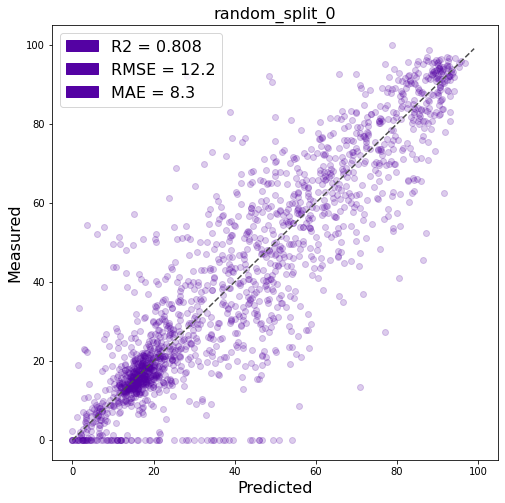

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_1 0.8310810040980006 11.560761386794958


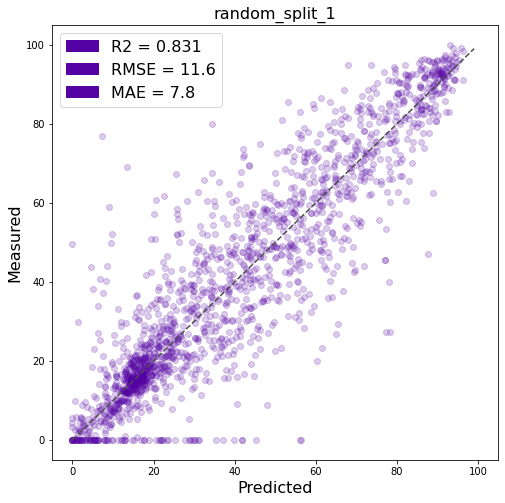

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_2 0.8394085269040579 11.266862592168955


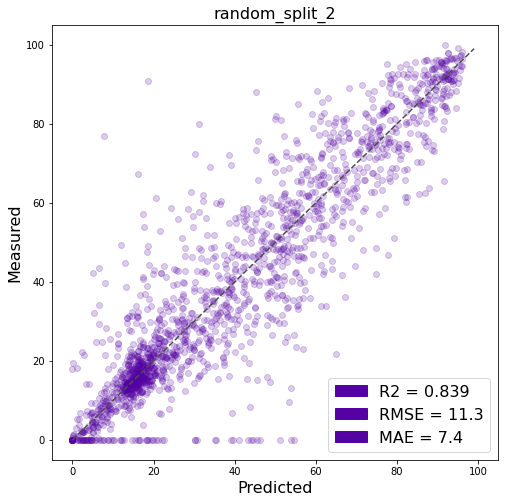

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_3 0.8207552201832418 11.851880946613178


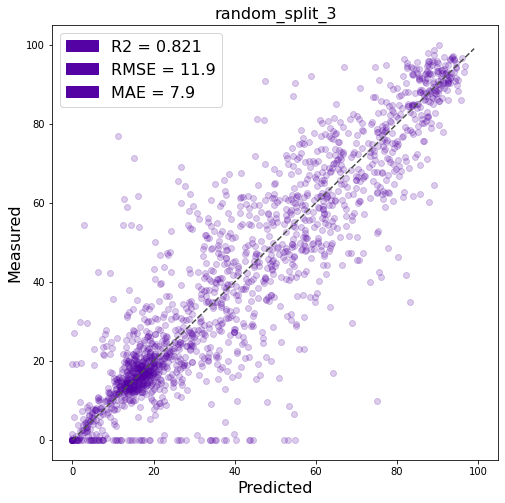

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_4 0.8170710840489845 11.943012886047017


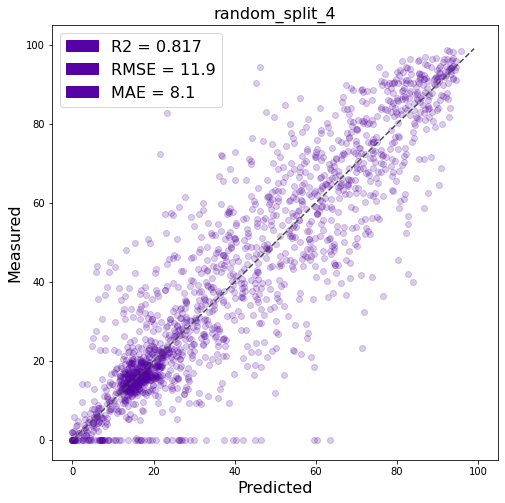

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_5 0.8051404223070073 12.333661591390168


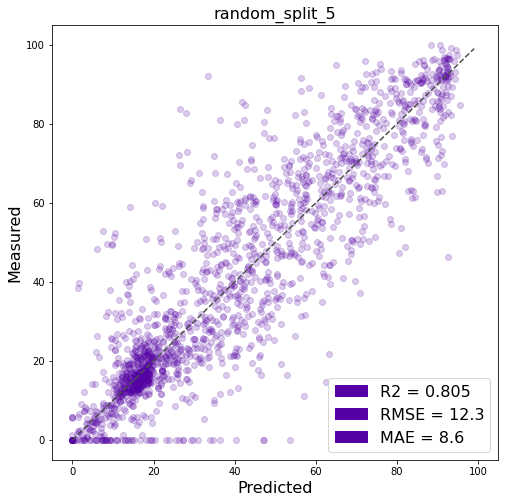

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_6 0.8066328331163081 12.583814214763247


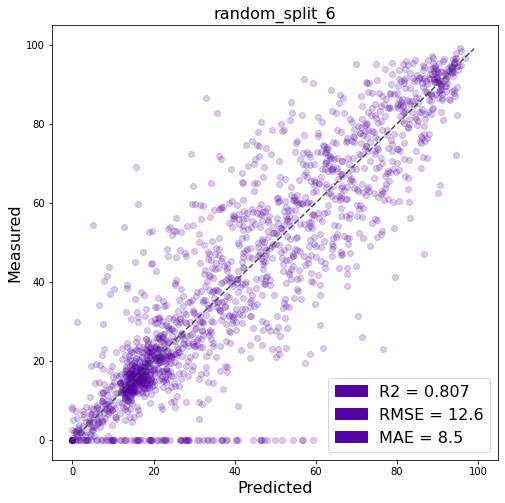

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_7 0.8224245308421634 11.71328356172294


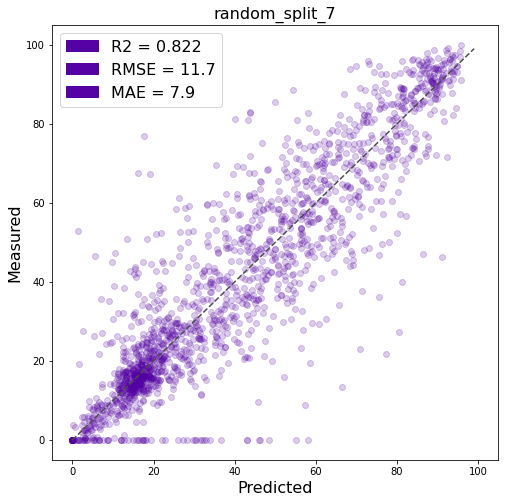

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_8 0.7963922429445431 12.792941460525222


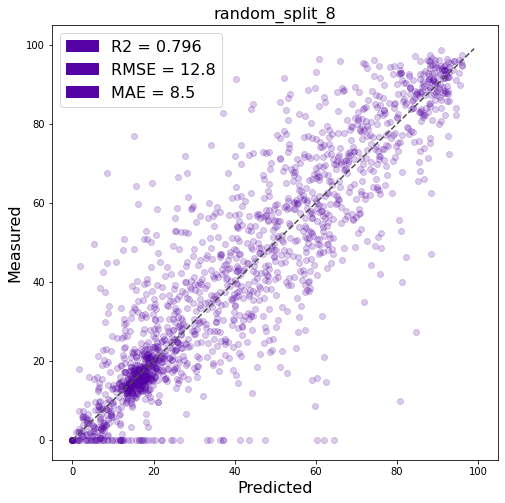

Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.



random_split_9 0.8018733166215921 12.494334012637955


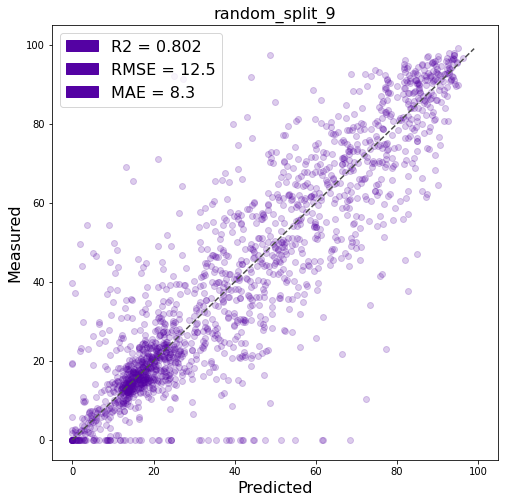

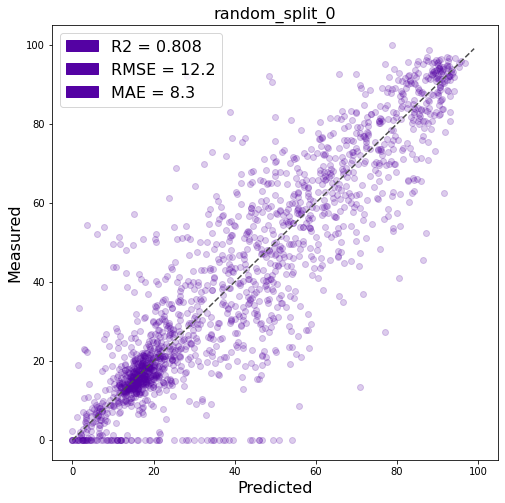

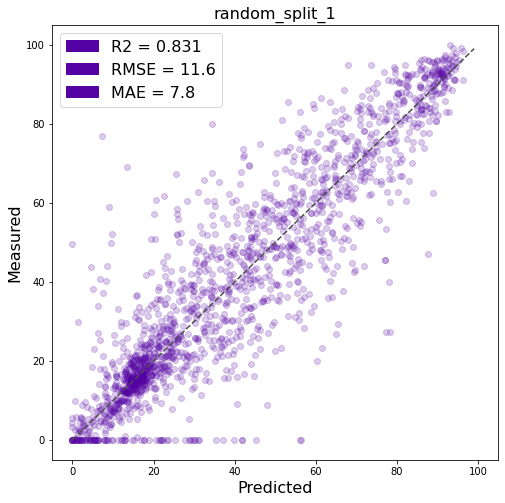

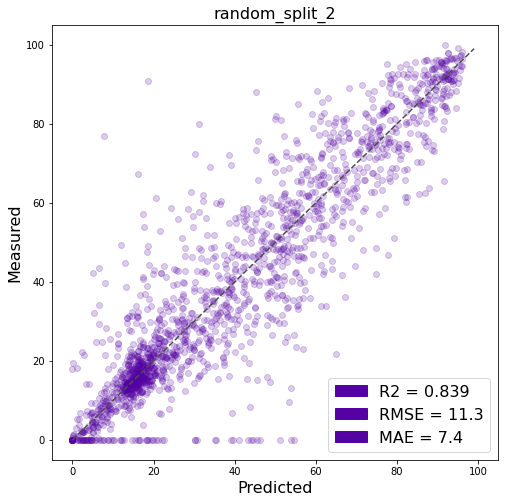

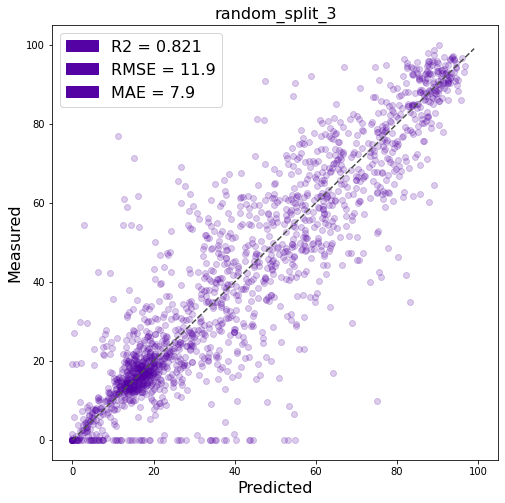

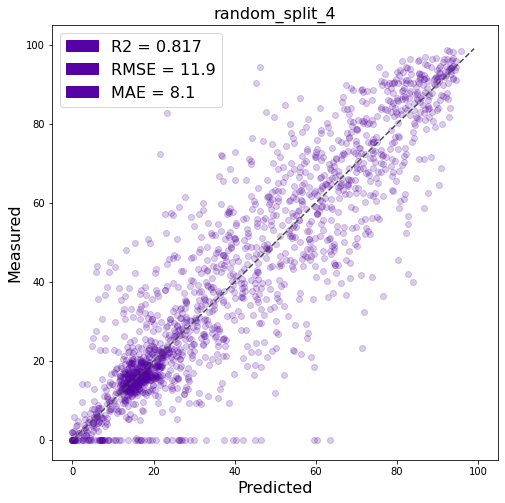

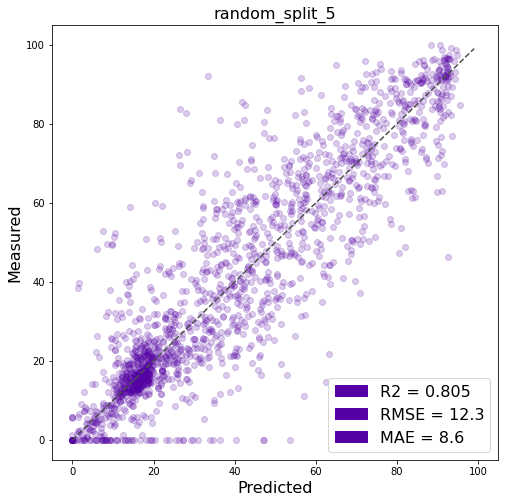

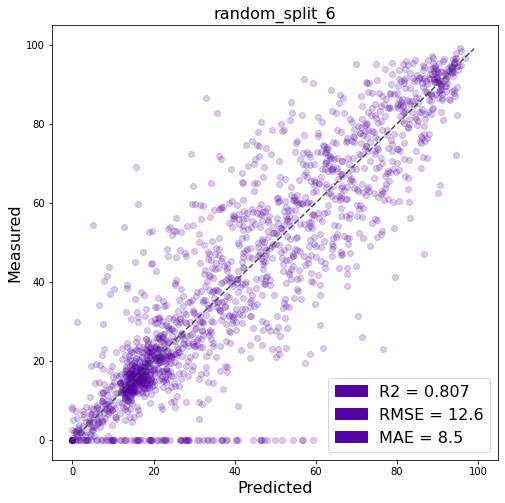

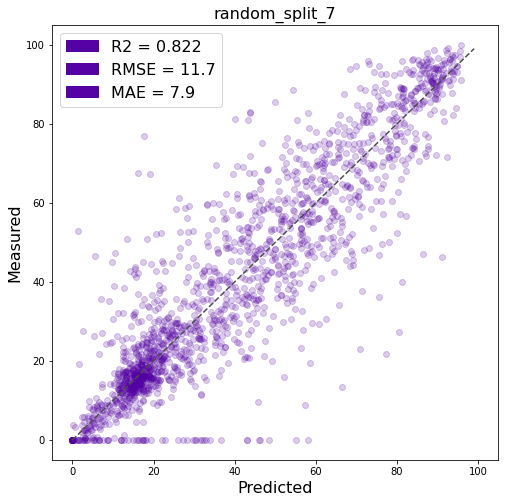

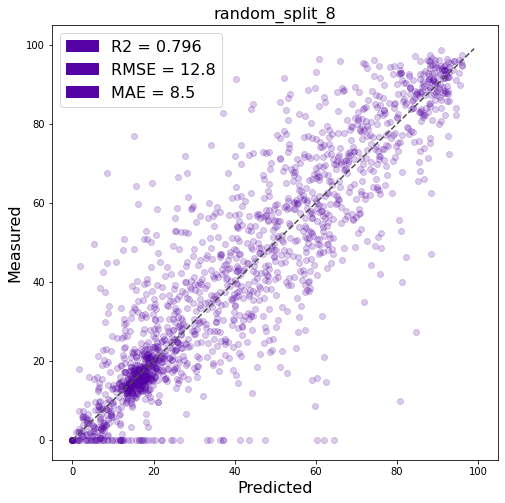

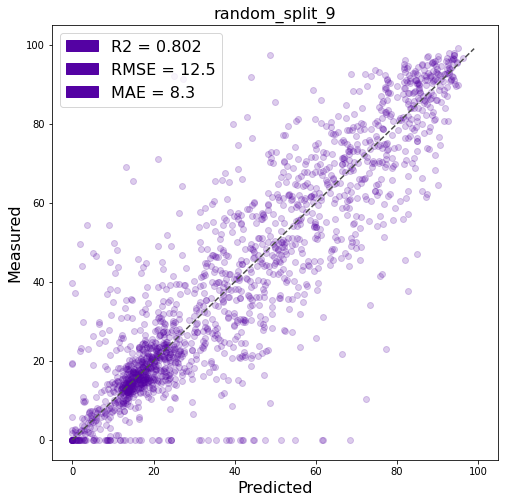

In [ ]:
# data
y_predictions = []
y_tests = []
r2_scores = []
rmse_scores = []

for (name, split) in NAME_SPLIT:

    df = pd.read_csv(f'../data/Suzuki-Miyaura/random_splits/{name}.tsv', sep='\t')

    
    train_df = df.iloc[:split][['rxn', 'y']] 
    test_df = df.iloc[split:][['rxn', 'y']] 

    train_df.columns = ['text', 'labels']
    test_df.columns = ['text', 'labels']

    mean = train_df.labels.mean()
    std = train_df.labels.std()


    model = load_model_from_results_folder(name, split)
    
    y_test = test_df['labels'].values * 100
    
    y_preds = model.predict(test_df.text.values)[0]
    
    y_preds = y_preds * std + mean
    
    y_preds = y_preds * 100
    
    y_preds = np.clip(y_preds, 0, 100)
    
    r_squared = r2_score(y_test, y_preds)
    rmse = mean_squared_error(y_test, y_preds) ** 0.5
    mae = mean_absolute_error(y_test, y_preds)
    
    r2_scores.append(r_squared)
    
    print(name, r_squared, rmse)
    fig = make_plot(y_test, y_preds, rmse, r_squared, mae, name)
    
    display(fig)
    
    # fig.savefig(f'images/mlst_perera_results/{name}_{split}.pdf')
    